## Loading libs

In [214]:
# File handling libs
import pandas as pd
import pprint
import glob
import csv
from os import listdir
from os.path import isfile, join, split

# Timeseries data
import datetime
from pandas.tseries.frequencies import to_offset

# Factor plot
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 10]
%matplotlib inline

# Linear Resampling irregular timeseries data
def resample(df, rate='T', short_rate='S', max_gap=None):
    """ Resample (unevenly spaced) timeseries data linearly by first upsampling to a
        high frequency (short_rate) then downsampling to the desired rate.
    
    :param df: a pandas timeseries object
    :param rate: rate that df should be resampled to
    :param short_rate: intermediate upsampling rate; if None, smallest interval of df is used
    :param max_gap: null intervals larger than `max_gap` are being treated as missing
        data and not interpolated. if None, always interpolate. must be provided as pandas
        frequency string format, e.g. '6h'
    """
    plt.rcParams['figure.figsize'] = [15, 10]
    
    # Resetting index to elapsed time 7200s
    # Setting first value to 0
    df.loc[-1] = df.loc[0]
    df.index = df.index + 1 
    df = df.sort_index() 
    df.loc[0,'elapsed_time'] = 0
    df.loc[0,'n_trial'] = 0

    # Setting last value to 7200
    df = df.loc[df['elapsed_time'] <= 7200]
    df = df.append(df.iloc[-1]).reset_index(drop=True)
    df.iloc[-1, df.columns.get_loc('elapsed_time')] = 7200
    df.iloc[-1, df.columns.get_loc('n_trial')] = df.iloc[-2, df.columns.get_loc('n_trial')]+1

    # Converting to timedelta and setting time as index
    df['elapsed_time'] = df['elapsed_time'].apply(lambda x : datetime.timedelta(seconds=x))
    df = df.set_index('elapsed_time')
    
    # return series if empty
    if df.empty:
        return df

    # check for timedelta index
    assert isinstance(
        df.index[0], pd.Timedelta), 'Object must have a datetime-like index.'

    # sort df by time
    df.sort_index(inplace=True)

    # create timedelta from frequency string
    rate_delta = to_offset(rate).delta

    # compute time intervals
    diff = np.diff(df.index) / np.timedelta64(1, 's')

    if max_gap is not None:
        # identify intervals in df larger than max_gap
        idx = np.where(np.greater(diff, to_offset(max_gap).delta.total_seconds()))[0]
        start = df.index[idx].tolist()
        stop = df.index[idx + 1].tolist()
        # store start and stop indices of large intervals
        big_gaps = list(zip(start, stop))

    if short_rate is None:
        # use minimal nonzero interval of original series as short_rate
        short_rate = '%dS' % diff[np.nonzero(diff)].min()
        # create timedelta from frequency string
        short_rate_delta = to_offset(short_rate).delta
        # if smallest interval is still larger than rate, use rate instead
        if short_rate_delta > rate_delta:
            short_rate = rate
    else:
        # convert frequency string to timedelta
        short_rate_delta = to_offset(short_rate).delta
        # make sure entered short_rate is smaller than rate
        assert rate_delta >= short_rate_delta, 'short_rate must be <= rate'

    # upsample to short_rate
    df = df.resample(short_rate).mean().interpolate()

    # downsample to desired rate
    df = df.resample(rate).ffill()

    # replace values in large gap itervals with NaN
    if max_gap is not None:
        for start, stop in big_gaps:
            df[start:stop] = None
    
    return df


def get_avg_losses():
    # Create df of full fps using glob to return all csv files under final dir
    files = pd.DataFrame([file for file in glob.glob("final/*/*.csv")], columns=["fullpath"])
    
    #    fullpath
    # 0  final\run_1\*.csv
    # 1  final\run_1\*.csv
    # ..

    # Split the full path into directory and filename
    files_split = files['fullpath'].str.rsplit("/", 1, expand=True).rename(columns={0: 'path', 1:'filename'})
    #    path       filename
    # 0  final\run_1  *.csv
    # 1  final\run_1  *.csv
    # ..
    
    print('# Files: %d # Runs: %d ' % (len(files), len(files_split['path'].unique())))
    # Join these into one DataFrame
    files = files.join(files_split)

    #    fullpath           path          filename
    # 0  final\run_1\*.csv   final\run_1  *.csv
    # 1  final\run_1\*.csv   final\run_1  *.csv
    # ..

    # Iterate over unique filenames; read CSVs, concat DFs
    avg_losses = pd.DataFrame()
    losses =pd.DataFrame()
    for fn in files['filename'].unique():
       # fn = files['filename'].unique()[1]
        name = fn.split('.')[0]
        print(name)

        dir, f = split(fn)
        f = f.split('_')
        if any(x in fn for x in ['default', 'ompl']):
            mode = f[-1].split('.')[-2]
        else:
            planner_fn = f[-1].split('.')[-2]
            mode = f[2]  

        paths = files[files['filename'] == fn]['fullpath'] # Get list of fullpaths from unique filenames
        dfs = []
        
        losses=pd.DataFrame()
        for idx, path in enumerate(paths):
            if not any(x in path for x in ['default', 'ompl']):
                df = pd.read_csv(path, index_col=False, sep=',').dropna(axis=1)
                df_resample = resample(df, '2S')
                df_resample = df_resample['loss']     
                dfs.append(df_resample) 
            else:
                df = pd.read_csv(path, index_col=False, sep=',').dropna(axis=1)
                df_resample = resample(df, '2S')
                df_resample = df_resample['t_avg_plan_time']     
                dfs.append(df_resample) # Get list of dataframes from CSV file paths

            losses = pd.concat([losses, pd.DataFrame({name+str(idx) :df_resample})], axis=1)

        avg_losses = pd.concat([avg_losses, pd.DataFrame({name :losses.mean(axis=1)})], axis=1)
    return avg_losses

def factor_plot(fps, planner_select, planner, mode_select=None):
    fps = sorted(fps.copy())
    plt.rcParams['figure.figsize'] = [15, 10]
    fig,ax = plt.subplots(1)
    cm = plt.get_cmap('jet')
    ax.set_prop_cycle('color', [cm(i) for i in np.linspace(0, 1, 10)])
    dir, fn = split(fps[0])
    
    elapsed_time = np.linspace(0, 7200, 500)
    default_fn = planner_select+'_default.csv'
    default_df = pd.read_csv(join(dir, default_fn), index_col=False)
    default = float(default_df[(default_df['planner'].str.contains(planner))]['t_avg_plan_time'])
    default_df = pd.DataFrame(
        {'elapsed_time': elapsed_time, 'default': default})
    default_df['default'] = default/default_df['default']
    ax.plot('elapsed_time', 'default', data=default_df, label='default')

    ompl_fn = planner_select+'_ompl.csv'
    ompl_df = pd.read_csv(join(dir, ompl_fn), index_col=False)
    ompl = float(ompl_df[(ompl_df['planner'].str.contains(planner))]['t_avg_plan_time'])
    ompl_df = pd.DataFrame({'elapsed_time': elapsed_time, 'ompl': ompl})
    ompl_df['ompl'] = default/ompl_df['ompl']
    ax.plot('elapsed_time', 'ompl', data=ompl_df, label='ompl')
    
    
    # Planner select filepaths
    for fp in fps:
        if planner_select in fp:
            if not any(x in fp for x in ['default', 'ompl']):
                # f = <planner_select>_<mode>_<planner>.csv
                dir, fn = split(fp)
                fn = fn.split('_')
                planner_fn = fn[-1].split('.')[-2]
                mode = fn[2]
                
                if (mode_select != None) and (mode not in mode_select):
                    fps.remove(fp)
                else:
                    # Filtering fns for selected planner
                    if re.search(planner_fn, planner, re.IGNORECASE): 
#                         print(fp)
                        mode_df = pd.read_csv(fp, index_col=False)
                        # Remove everything slower than ompl baseline
                        # mode_df.drop(mode_df[mode_df.loss >= ompl].index, inplace=True)
                        max_speed_up = default
                        speed_up = list(mode_df['loss'])
                        for idx, loss in enumerate(speed_up):
                            if loss < max_speed_up:
                                max_speed_up = loss
                            else:
                                speed_up[idx] = max_speed_up
                                                                   
                        mode_df = pd.DataFrame({'elapsed_time': mode_df['elapsed_time'], mode: speed_up})
                        mode_df[mode+'_factor'] = default/mode_df[mode]
                        ax.plot('elapsed_time', mode+'_factor', data=mode_df, label=mode+'_factor')

    
    plt.title(planner_select + ' ' + planner)
    plt.xticks([0, 1440, 2880, 4320, 5760, 7200])
    #                     plt.yticks([0.8, 1.6, 2.4, 3.1, 3.9, 4.7])
    plt.xlabel('Time spent exploring solutions (secs)')
    plt.ylabel('Speed up over default (secs)')
    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles,labels,loc='upper right')
    plt.show()

def avg_factor_plot(avg_losses, planner_select, planner, benchmark='default', mode_select=None):
    plt.rcParams['figure.figsize'] = [15, 10]
    df = avg_losses.copy()
    def_cols = [planner_select+'_default', planner_select+'_ompl']
    cols = [c for c in df.columns if planner_select in c if planner in c]
    cols = sorted(cols)
    cols = def_cols + cols

    ps_df = df[cols]
    legend = [c.split('_')[2] for c in cols]
    ps_df.columns = legend

    bm = float(ps_df['default'][0])
    if benchmark == 'ompl':
        bm = float(ps_df['ompl'][0])
        
    speedup_df = pd.DataFrame({'default': bm/ps_df['default'], 'ompl': bm/ps_df['ompl']})
    
    modes = legend
    if (mode_select != None):
        modes = ['default', 'ompl']
        modes = modes+ mode_select

    for mode in modes:
        if not any(x in mode for x in ['default', 'ompl']): 
            speedup = list(ps_df[mode])
            max_speedup = bm
            for idx, loss in enumerate(speedup):
                if loss < max_speedup:
                    max_speedup = loss
                else:
                    speedup[idx] = max_speedup

            mode_df = pd.Series(speedup, index=ps_df[mode].index, name=mode)
            mode_df = bm/mode_df
            speedup_df = pd.concat([speedup_df, mode_df], axis=1)
    
#     xtick_vals = [0, 1440, 2880, 4320, 5760, 7200] 
#     xtick_vals =  pd.to_timedelta([datetime.timedelta(seconds=x) for x in xtick_vals])
#     xtick_vals = [strdatetime.timedelta(seconds=x)) for x in xtick_vals]
# #     print(xticks_vals)
    ax = speedup_df.plot(title=planner_select+' '+planner, colormap='jet')
    
    ax.set_xlabel('Time spent exploring solutions (secs)')
    ax.set_ylabel('Speed up over default (secs)')
    ax.legend(loc='upper right')


#     ax.set_xticks(xticks_vals)
#     ax.set_xticklabels(str(xticks_vals))

In [211]:
avg_losses = get_avg_losses()
avg_losses.head()

# Files: 132 # Runs: 3 
Cano_etal_ompl
Burger_etal_gp_BKPIECE
Cano_etal_rf_BKPIECE
Burger_etal_rand_BiTRRT
Burger_etal_tpe_BiTRRT
Cano_etal_tpe_BKPIECE
Burger_etal_tpe_BKPIECE
Cano_etal_gp_BKPIECE
Cano_etal_et_BKPIECE
Burger_etal_aucbandit_BiTRRT
Burger_etal_aucbandit_RRTConnect
Burger_etal_et_RRTConnect
Burger_etal_rand_RRTConnect
Burger_etal_aucbandit_BKPIECE
Burger_etal_rf_BiTRRT
Burger_etal_gbrt_BiTRRT
Cano_etal_rand_RRTConnect
Burger_etal_gbrt_BKPIECE
Cano_etal_rf_RRTConnect
Burger_etal_ompl
Burger_etal_gbrt_RRTConnect
Burger_etal_et_BKPIECE
Burger_etal_smac_RRTConnect
Cano_etal_smac_RRTConnect
Burger_etal_gp_RRTConnect
Cano_etal_et_RRTConnect
Cano_etal_smac_BKPIECE
Burger_etal_rf_RRTConnect
Cano_etal_rand_BKPIECE
Burger_etal_et_BiTRRT
Cano_etal_gbrt_RRTConnect
Burger_etal_rand_BKPIECE
Burger_etal_smac_BiTRRT
Burger_etal_default
Cano_etal_gbrt_BKPIECE
Cano_etal_aucbandit_BKPIECE
Cano_etal_aucbandit_RRTConnect
Burger_etal_gp_BiTRRT
Burger_etal_tpe_RRTConnect
Burger_etal_rf_BKPIECE


,Cano_etal_ompl,Burger_etal_gp_BKPIECE,Cano_etal_rf_BKPIECE,Burger_etal_rand_BiTRRT,Burger_etal_tpe_BiTRRT,Cano_etal_tpe_BKPIECE,Burger_etal_tpe_BKPIECE,Cano_etal_gp_BKPIECE,Cano_etal_et_BKPIECE,Burger_etal_aucbandit_BiTRRT,...,Cano_etal_gbrt_BKPIECE,Cano_etal_aucbandit_BKPIECE,Cano_etal_aucbandit_RRTConnect,Burger_etal_gp_BiTRRT,Burger_etal_tpe_RRTConnect,Burger_etal_rf_BKPIECE,Cano_etal_tpe_RRTConnect,Cano_etal_gp_RRTConnect,Cano_etal_default,Burger_etal_smac_BKPIECE
elapsed_time,,,,,,,,,,,,,,,,,,,,,
00:00:00,1.590309,2.696523,2.135278,0.824219,0.398186,2.316467,1.655337,1.714505,2.456693,0.717027,...,1.523755,3.000000,0.493213,0.438820,1.982801,2.182347,1.079745,0.600708,1.005983,0.760991
00:00:02,1.590309,2.696523,2.135278,0.824219,0.398186,2.316467,1.655337,1.714505,2.456693,0.717027,...,1.523755,3.000000,0.493213,0.438820,1.982801,2.182347,1.079745,0.600708,1.005983,0.873869
00:00:04,1.590309,2.657992,2.093338,0.824219,0.421760,2.316467,1.655337,1.714505,2.456693,0.717027,...,1.523755,3.000000,0.493688,0.438820,1.922304,2.143274,1.085512,0.600708,1.005983,0.986747
00:00:06,1.590309,2.580930,2.173280,0.793389,0.468908,2.316467,1.655337,1.575264,2.350667,0.717027,...,1.407117,2.666077,0.494638,0.438820,1.940867,2.298744,1.097046,0.600708,1.005983,1.099624
00:00:08,1.590309,2.503867,2.253222,0.731730,0.516055,2.351115,1.774574,1.436022,2.240411,0.714818,...,1.207063,2.332154,0.499251,0.435693,2.038489,2.454214,1.074835,0.600453,1.005983,1.212502


## Speedup Factor Plots

In [130]:
results_fps_1 = [file for file in glob.glob(join('final', 'run_1', '*.csv'))]
print(len(results_fps_1))

results_fps_2 = [file for file in glob.glob(join('final', 'run_2', '*.csv'))]
print(len(results_fps_2))

results_fps_3 = [file for file in glob.glob(join('final', 'run_3', '*.csv'))]
print(len(results_fps_3))

44
44
44


### Cano_etal BKPIECE

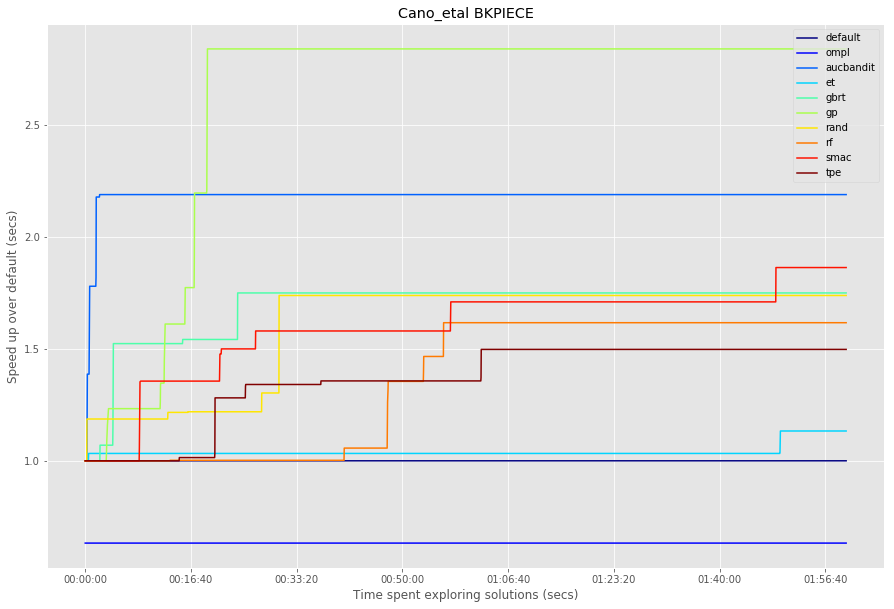

In [217]:
avg_factor_plot(avg_losses, 'Cano_etal', 'BKPIECE' )

In [201]:
# factor_plot(results_fps_1, 'Cano_etal', 'BKPIECE')
# factor_plot(results_fps_2, 'Cano_etal', 'BKPIECE')
# factor_plot(results_fps_3, 'Cano_etal', 'BKPIECE')

### Cano_etal RRTConnect


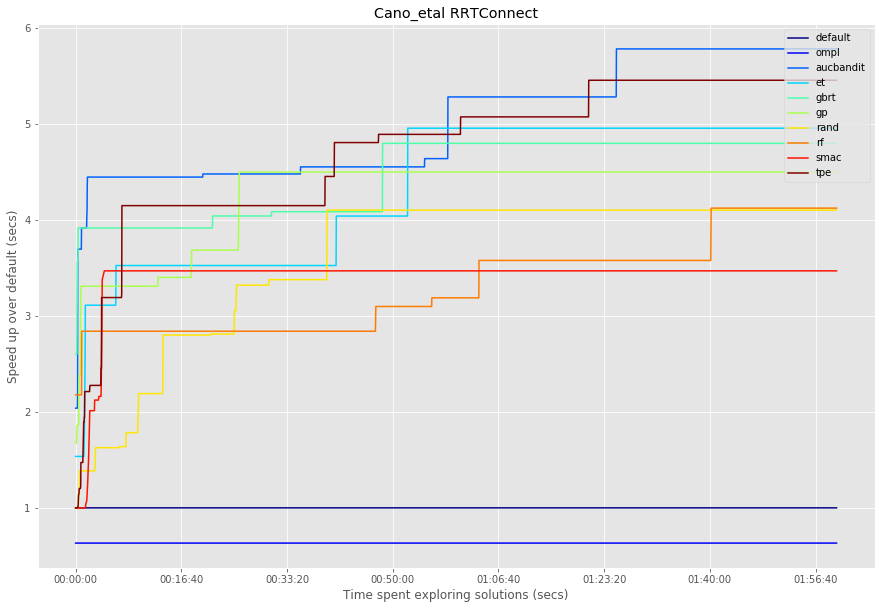

In [139]:
avg_factor_plot(avg_losses, 'Cano_etal', 'RRTConnect')

In [202]:
# factor_plot(results_fps_1, 'Cano_etal', 'RRTConnect')
# factor_plot(results_fps_2, 'Cano_etal', 'RRTConnect')
# factor_plot(results_fps_3, 'Cano_etal', 'RRTConnect')

### Burger_etal BKPIECE

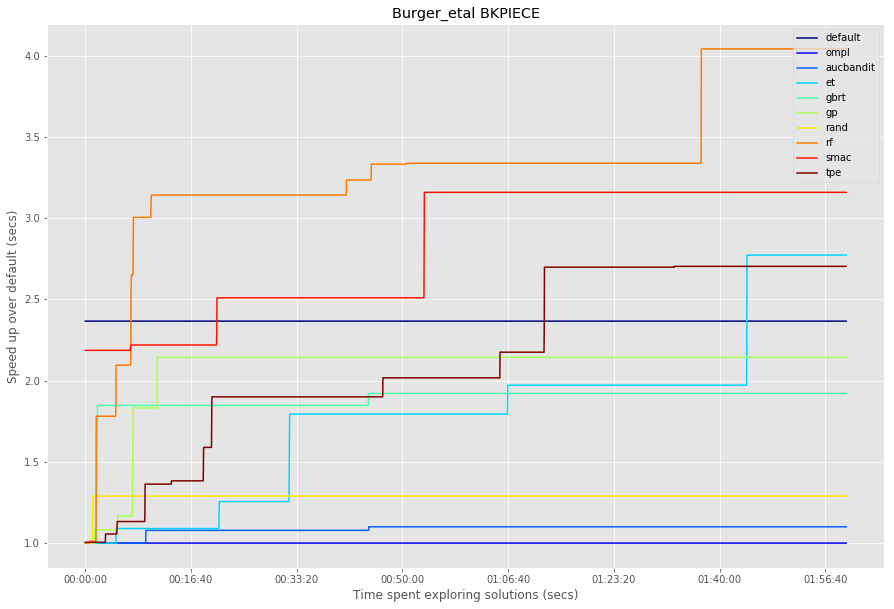

In [219]:
avg_factor_plot(avg_losses, 'Burger_etal', 'BKPIECE' ,benchmark='ompl' )

In [ ]:
# factor_plot(results_fps_1, 'Burger_etal', 'BKPIECE')
# factor_plot(results_fps_2, 'Burger_etal', 'BKPIECE')
# factor_plot(results_fps_3, 'Burger_etal', 'BKPIECE')

### Burger_etal RRTConnect

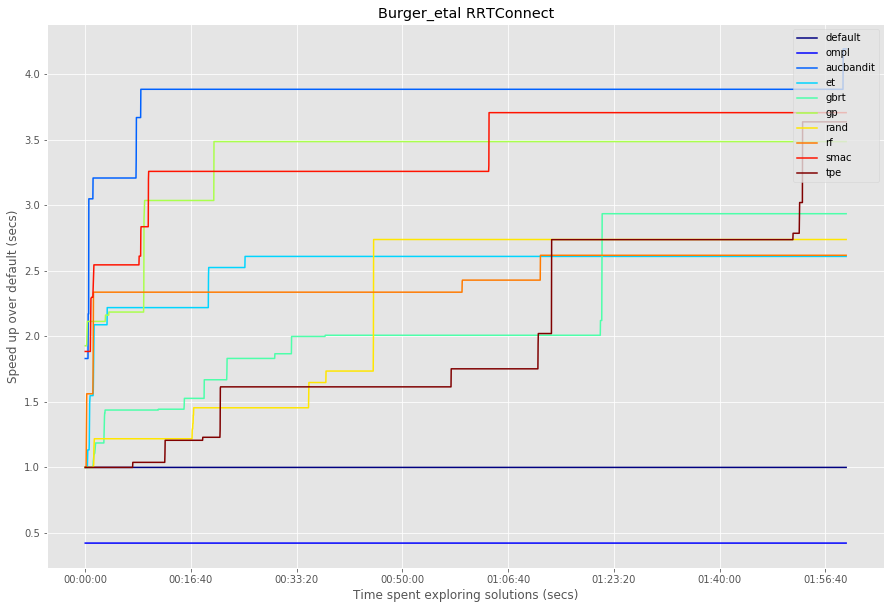

In [141]:
avg_factor_plot(avg_losses, 'Burger_etal', 'RRTConnect')

In [ ]:
# factor_plot(results_fps_1, 'Burger_etal', 'RRTConnect')
# factor_plot(results_fps_2, 'Burger_etal', 'RRTConnect')
# factor_plot(results_fps_3, 'Burger_etal', 'RRTConnect')

### Burger_etal BiTRRT

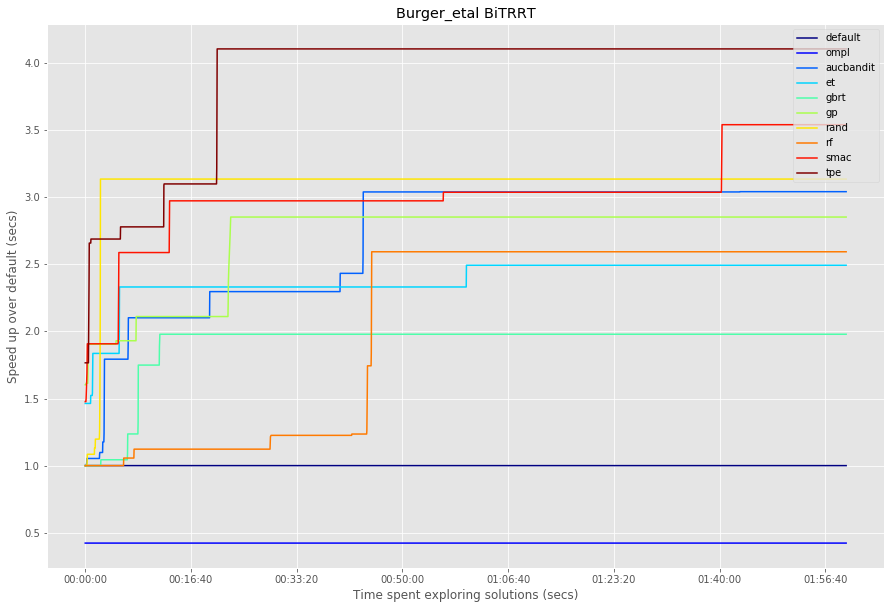

In [142]:
avg_factor_plot(avg_losses, 'Burger_etal', 'BiTRRT')

In [ ]:
# factor_plot(results_fps_1, 'Burger_etal', 'BiTRRT')
# factor_plot(results_fps_2, 'Burger_etal', 'BiTRRT')
# factor_plot(results_fps_3, 'Burger_etal', 'BiTRRT')